<a href="https://colab.research.google.com/github/LogeswaranSR/PRODIGY_ML_04/blob/main/Hand_Gesture_Recognition_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gti-upm/leapgestrecog
! unzip leapgestrecog.zip

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
path = "./leapGestRecog"
folders = os.listdir(path)
inner_folders = os.listdir(path+"/01")
categories=[]
for i in inner_folders:
  category = i.split('_', maxsplit=1)[1:]
  categories.append(category[0])
num_classes = len(categories)
categories

['index',
 'c',
 'fist',
 'fist_moved',
 'palm_moved',
 'ok',
 'l',
 'down',
 'palm',
 'thumb']

In [4]:
df = pd.DataFrame(columns=['filepaths','categories'])
paths , category = [], []
for folder in folders:
  inner_folders = os.listdir(path+'/'+folder)
  for inner_f in inner_folders:
    files = os.listdir(path+'/'+folder+"/"+inner_f)
    for file in files:
      paths.append(folder+'/'+inner_f+'/'+file)
      category.append(inner_f.split('_', maxsplit=1)[1])
df['filepaths'] = paths
df['categories'] = category

In [7]:
im_size = (224, 224)
im_width, im_height = im_size
im_channels=1
batch_size = 50

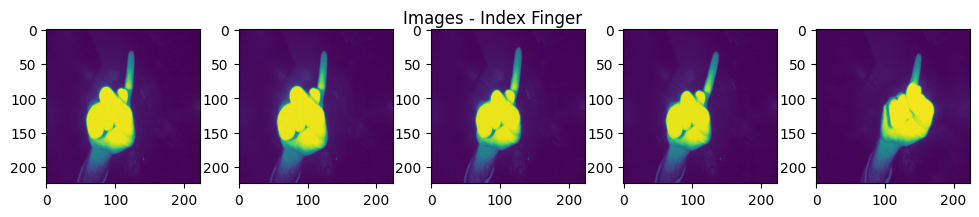

In [21]:
fig = plt.figure(figsize=(12,2))
fig.suptitle("Images - Index Finger")

for i in range(5):
  img = Image.open(path+'/'+df['filepaths'][i])
  img = img.resize(im_size)
  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  # print(img.shape)
plt.show()

In [8]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=123)
train_df[:5]

,filepaths,categories
9642,09/01_palm/frame_09_01_0024.png,palm
17924,08/05_thumb/frame_08_05_0062.png,thumb
1642,04/01_palm/frame_04_01_0001.png,palm
9670,09/01_palm/frame_09_01_0078.png,palm
16860,08/08_palm_moved/frame_08_08_0108.png,palm_moved


In [9]:
train_datagen = ImageDataGenerator(rescale=1/.255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 16000 validated image filenames belonging to 10 classes.


In [10]:
val_datagen = ImageDataGenerator(rescale=1/.255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


## Model Definition

In [22]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(im_size[0], im_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (5,5), activation='relu'),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [23]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Model Training

In [24]:
model_hist = model.fit(
    train_generator,
    validation_data = val_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
100/100 [==============================] - 49s 378ms/step - loss: 4.4457 - acc: 0.0978 - val_loss: 2.3029 - val_acc: 0.0775 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 39s 389ms/step - loss: 2.3023 - acc: 0.0954 - val_loss: 2.3009 - val_acc: 0.0955 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 39s 391ms/step - loss: 2.2811 - acc: 0.1298 - val_loss: 2.1952 - val_acc: 0.1750 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 40s 399ms/step - loss: 2.2110 - acc: 0.1758 - val_loss: 2.0846 - val_acc: 0.2250 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 41s 409ms/step - loss: 2.1316 - acc: 0.1956 - val_loss: 1.9865 - val_acc: 0.2370 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 40s 400ms/step - loss: 2.0991 - acc: 0.1838 - val_loss: 1.9693 - val_acc: 0.2045 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 2.0716 - acc: 0.1984
Epoch 7: Reduc

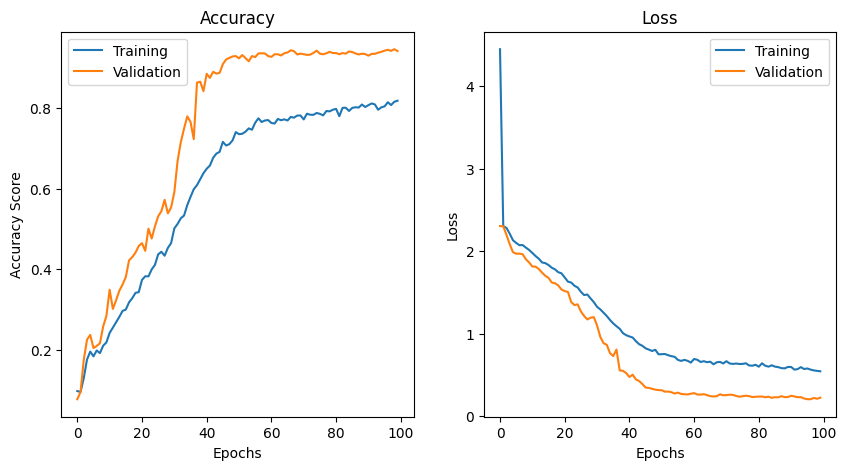

In [25]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['acc'], label='Training')
plt.plot(model_hist.history['val_acc'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_hist.history['loss'], label='Training')
plt.plot(model_hist.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.savefig("Training History.jpg")
plt.show()

In [26]:
model.save('hand_gesture_recognition.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [27]:
basic_test_generator = train_datagen.flow_from_dataframe(
    test_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


In [28]:
loss, acc = model.evaluate(basic_test_generator)
print("Testing Loss:", loss)
print("Testing Accuracy:", acc)

40/40 [==============================] - 13s 328ms/step - loss: 0.3871 - acc: 0.8810
Testing Loss: 0.3871236741542816
Testing Accuracy: 0.8809999823570251


## Inference

In [29]:
from PIL import Image

In [30]:
test_df[40:48]

,filepaths,categories
4662,05/04_fist_moved/frame_05_04_0091.png,fist_moved
13352,02/02_l/frame_02_02_0200.png,l
13647,02/01_palm/frame_02_01_0114.png,palm
5615,05/01_palm/frame_05_01_0081.png,palm
17957,08/05_thumb/frame_08_05_0067.png,thumb
15652,07/01_palm/frame_07_01_0073.png,palm
9179,09/07_ok/frame_09_07_0142.png,ok
5668,05/01_palm/frame_05_01_0179.png,palm


In [51]:
sample_imgs=[]
for img_paths in test_df[100:108]['filepaths']:
  img = Image.open(path+'/'+img_paths)
  img = img.resize(im_size)
  img = img.convert('L')
  img = np.array(img)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)
sample_imgs.shape

(8, 224, 224, 1)

In [52]:
preds = model.predict(sample_imgs)
preds = np.argmax(preds, axis=1)

1/1 [==============================] - 0s 24ms/step


In [53]:
preds

array([3, 3, 3, 4, 8, 8, 2, 4])

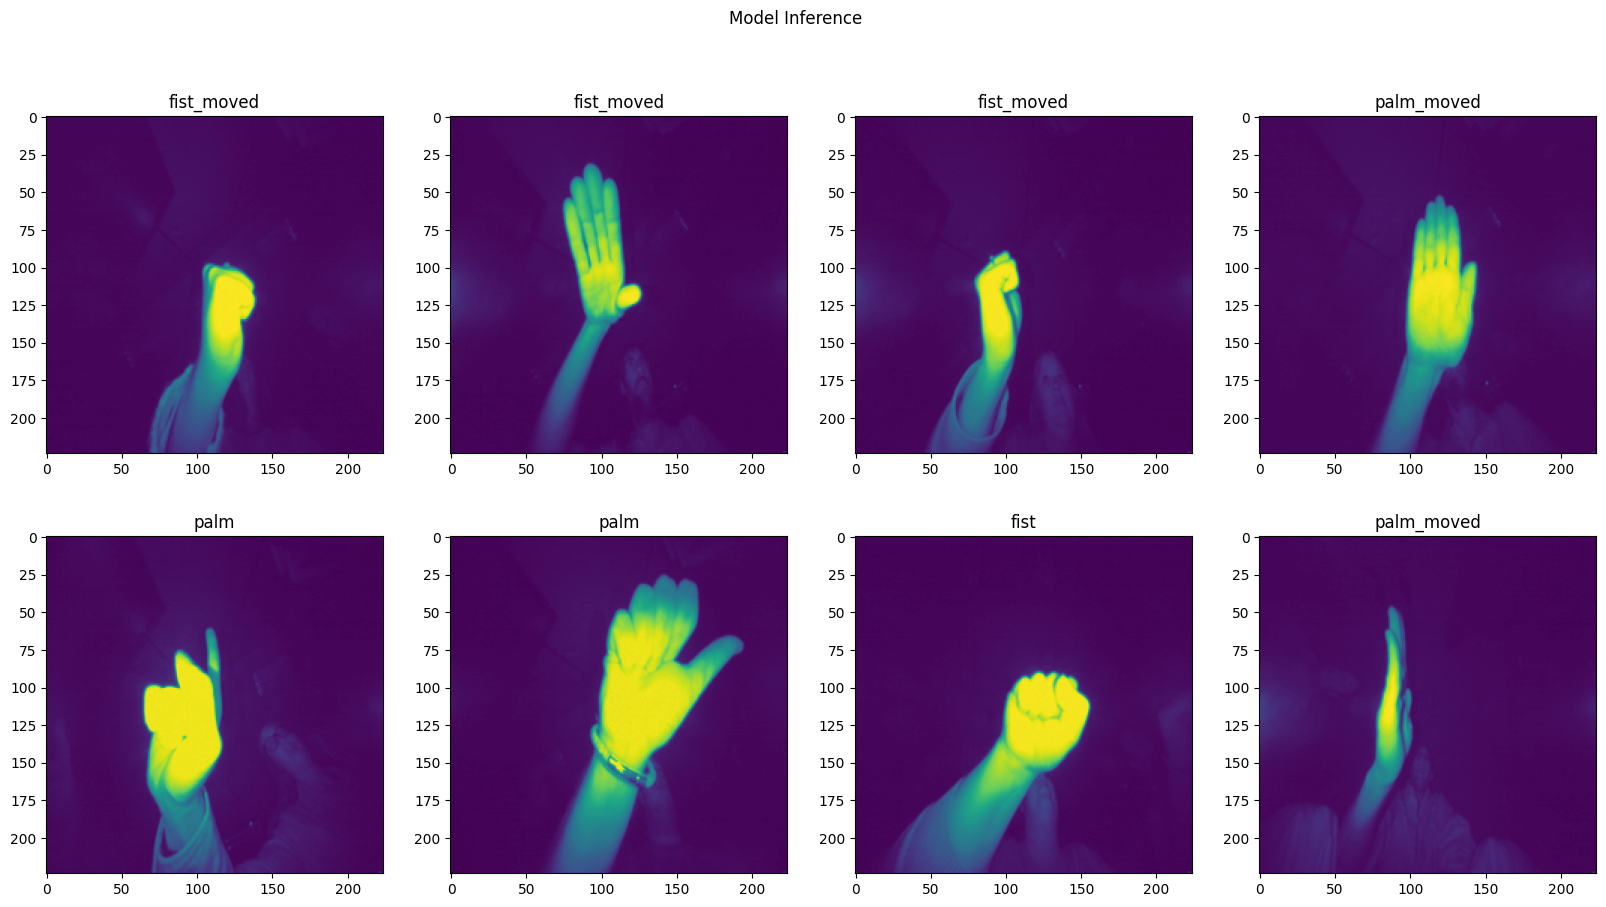

In [54]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Model Inference")
ind=1
for img in sample_imgs:
  plt.subplot(2,4,ind)
  plt.imshow(img)
  plt.title(categories[preds[ind-1]])
  ind+=1
plt.savefig("Hand Gesture model Inference.jpg")
plt.show()